# **2D Super-resolution pipeline**
___  
  
In this notebook, we demonstrate the use of the [BiaPy](https://biapy.readthedocs.io/en/latest/) pipeline for **2D super-resolution**, for reconstructing high-resolution (HR) images from low-resolution(LR).

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/LR_sr.png' width='250px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/HR_sr.png' width='250px'/>
<figcaption><b>Figure 1</b>: Example of a 2D super-resolution problem. Images obtained from <a href="https://www.dropbox.com/s/9f9xat4jbgkdchh/F-actin-small.zip?dl=0">F-actin dataset</a> provided in <a href="https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki">ZeroCostDL4Mic</a> notebooks for super-resolution.</figcaption></center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/danifranco/BiaPy/issues). Thank you!

## **Expected inputs and outputs**
___
### **Inputs**

This notebook expects five folders as input:
* **Training LR images**: with the low resolution 2D images to train the model.
* **Training HR images**: with the high resolution 2D images to train the model. Their number and sizes must match those of the training raw images.
* **Test LR images**: with the raw 2D images to test the model.
* **Test HR images**: with the high resolution 2D images to test the model. Their number and sizes must match those of the validation raw images.
* **Output folder**: a path to store the super-resolution results.

**Outputs**

Upon successful execution, a new folder will be generated containing one result **TIFF image** for every test image. These result images will showcase the instances of the objects of interest as determined by our pipeline.

<font color='red'><b>Note:</b></font> For testing, this notebook can be executed using the **example datasets found under 'Manage file(s) source > Option 3'**.


## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.

### **Option 1: Upload Files from Your Local Machine**
---

When you select this option, you'll be prompted to upload your files to Colab. Once uploaded, they will be stored in the `/content/input/` directory.


In [ ]:
#@markdown ##Play the cell to upload local files (train LR images)
from google.colab import files
!mkdir -p /content/input/train/LR
%cd /content/input/train/LR
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (train HR images)

from google.colab import files
!mkdir -p /content/input/train/HR
%cd /content/input/train/HR
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test LR images)

from google.colab import files
!mkdir -p /content/input/test/LR
%cd /content/input/test/LR
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test HR images)

from google.colab import files
!mkdir -p /content/input/test/HR
%cd /content/input/test/HR
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: download an example dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.

Specifically, we'll use the [F-actin dataset](https://www.dropbox.com/s/9f9xat4jbgkdchh/F-actin-small.zip?dl=0) shared in [ZeroCostDL4Mic](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for super-resolution notebooks.

In [ ]:
#@markdown ##Play to download an example dataset

import os
#https://drive.google.com/file/d/19ewMOWQArW3jzXS3hKus_fuz-UBf2Opb/view?usp=sharing
os.chdir('/content/')
!curl -L -s -o data_2d.zip 'https://drive.google.com/uc?id=1rtrR_jt8hcBEqvwx_amFBNR7CMP5NXLo&confirm=t'
!unzip -q data_2d.zip
!rm data_2d.zip



print('Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.

## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)** or **Option 3 (Use Our Sample Data)**:
  - Set `train_lr_data_path`: `/content/data/train/LR`
  - Set `train_hr_data_path` `/content/data/train/HR`
  - Set `test_lr_data_path` `/content/data/test/LR`
  - Set `test_hr_data_path` `/content/data/test/HR`
  - Set `output_path` `/content/out`
  
  **Note**: Ensure you download your results from the `/content/out` directory after the process!

- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_lr_data_path = '/content/data/train/LR' #@param {type:"string"}
#@markdown #####Path to train images
train_hr_data_path = '/content/data/train/HR' #@param {type:"string"}
#@markdown #####Path to test images
test_lr_data_path = '/content/data/test/LR' #@param {type:"string"}
#@markdown #####Path to test images
test_hr_data_path = '/content/data/test/HR' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**

In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
from skimage.exposure import match_histograms

# Clone the repo
os.chdir('/content/')
if not os.path.exists('BiaPy'):
    !git clone --depth 1 https://github.com/danifranco/BiaPy.git
    !pip install --upgrade --no-cache-dir gdown &> /dev/null
    sys.path.insert(0, 'BiaPy')
    os.chdir('/content/BiaPy')

    # # Install dependencies
    !sed -i '/pandas/d' /content/BiaPy/setup.py
    !pip install --editable .
else:
    print( 'Using existing installed version of BiaPy' )

Cloning into 'BiaPy'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 158 (delta 41), reused 61 (delta 14), pack-reused 0
Receiving objects: 100% (158/158), 36.14 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Obtaining file:///content/BiaPy
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

## **Configure and train the DNN model**
[BiaPy](https://biapy.readthedocs.io/en/latest/) contains a large list of deep learning models to perform semantic segmentation.

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**

* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data folder order as the ground truth class to measure the performance of the model's result. **Default value: True**

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as the backbone of the pipeline. Options: EDSR, RCAN, WDSR, DFCAN, U-Net, Residual U-Net, Attention U-Net, SEUNet, MultiResUNet, ResUNet++ (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1)). **Default value: EDSR**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 6**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 256**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization.**Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.0001**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

In [ ]:
#@markdown ### **Select your parameters**

#@markdown ---
#@markdown #### **Name of the model**
model_name = "my_2d_super_resolution" #@param {type:"string"}

#@markdown #### **Data management**
percentage_validation = 10 #@param {type:"number"}
test_ground_truth = True #@param {type:"boolean"}

#@markdown #### **Basic training parameters**
number_of_epochs = 50 #@param {type:"number"}
patience = 10 #@param {type:"number"}

#@markdown #### **Advanced Parameters - experienced users only**
model_architecture = "EDSR" #@param ["EDSR", "RCAN", "WDSR", "DFCAN", "U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'ResUNet++', 'SEUNet']
batch_size = 6 #@param {type:"number"}
patch_size = 48 # @param {type:"number"}
input_channels = 1 #@param {type:"number"}
optimizer = "ADAMW" #@param ["ADAM", "ADAMW", "SGD"]
initial_learning_rate = 0.0001 #@param {type:"number"}
test_time_augmentation = False #@param {type:"boolean"}


In [ ]:
#@markdown ##Play to download the YAML configuration file and update it to train the model
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_super-resolution.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/danifranco/BiaPy/master/templates/super-resolution/2d_super-resolution.yaml &> /dev/null

# Check files before modifying the .yaml file
if not os.path.exists(train_lr_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_lr_data_path)
ids = sorted(next(os.walk(train_lr_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(train_lr_data_path))
else:
    from skimage.io import imread
    img_dtype = imread(os.path.join(train_lr_data_path, ids[0])).dtype

if not os.path.exists(train_hr_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_hr_data_path)
ids = sorted(next(os.walk(train_hr_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(train_hr_data_path))

if not os.path.exists(test_lr_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_lr_data_path)
ids = sorted(next(os.walk(test_lr_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(test_lr_data_path))

if test_ground_truth:
    if not os.path.exists(test_hr_data_path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_hr_data_path)
    ids = sorted(next(os.walk(test_hr_data_path))[2])
    if len(ids) == 0:
        raise ValueError("No files found in dir {}".format(test_hr_data_path))

# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_lr_data_path
biapy_config['DATA']['TRAIN']['GT_PATH'] = train_hr_data_path
biapy_config['DATA']['TEST']['PATH'] = test_lr_data_path
biapy_config['DATA']['TEST']['GT_PATH'] = test_hr_data_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# Change normalization to 'custom' if dtype is uint16
if img_dtype == np.uint16:
    biapy_config['DATA']['NORMALIZATION'] = {}
    biapy_config['DATA']['NORMALIZATION']['TYPE'] = 'custom'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# Transcribe model architecture
architecture = 'edsr'
if model_architecture == "RCAN":
    architecture = 'rcan'
elif model_architecture == "WDSR":
    architecture = 'wdsr'
elif model_architecture == "SRUNET":
    architecture = 'srunet'
elif model_architecture == "DFCAN":
    architecture = 'dfcan'
elif model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
biapy_config['MODEL']['ARCHITECTURE'] = architecture

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth
biapy_config['TEST']['ENABLE'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")


Training configuration finished.


### **Train the model**
---

In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['PATHS'] = {}
biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

In [ ]:
#@markdown ##Play to train the model

import os
import errno

# Run the code
os.chdir('/content/BiaPy')
!python -u main.py --config '/content/'{job_name}'.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0


Date: 2023-10-16 13:15:09
Arguments: Namespace(config='/content/my_2d_super_resolution.yaml', result_dir='/content/output', name='my_2d_super_resolution', run_id=1, gpu='0', world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_super_resolution_1
Python       : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
PyTorch:  2.0.1+cu118
Not using distributed mode
[13:15:09.795234] Configuration details:
[13:15:09.795284] AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM: False
  CONTRAST_EM_FACTOR: (-0.1, 0.1)
  CONTRAST_EM_MODE

## **Inspection of the Loss Function and the peak signal-to-noise ratio (PSNR)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.


The **peak signal-to-noise ratio (PSNR)**, offers a means to evaluate the quality of the prediction against the ground truth. The higher value the better image you are creating.


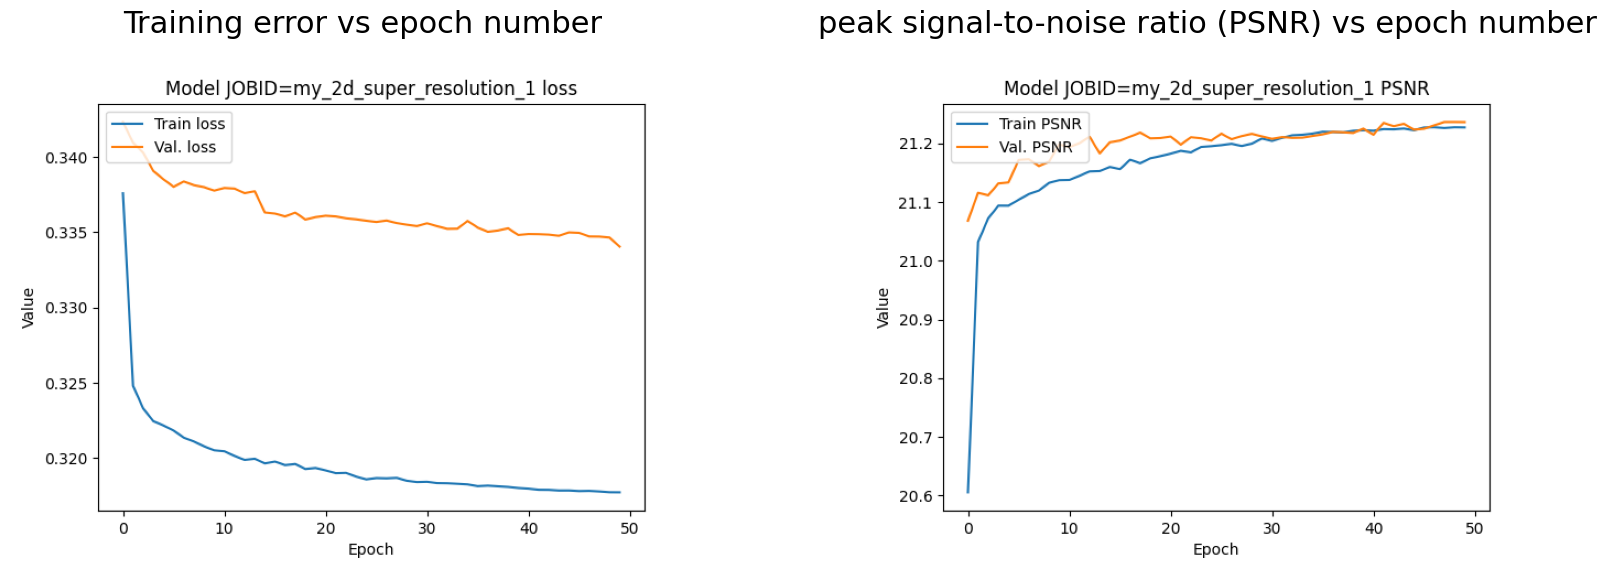

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and PSNR vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

psnr = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_PSNR.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( psnr )
_ = plt.axis('off')
_= ax2.set_title( 'peak signal-to-noise ratio (PSNR) vs epoch number', fontdict = {'fontsize':22})

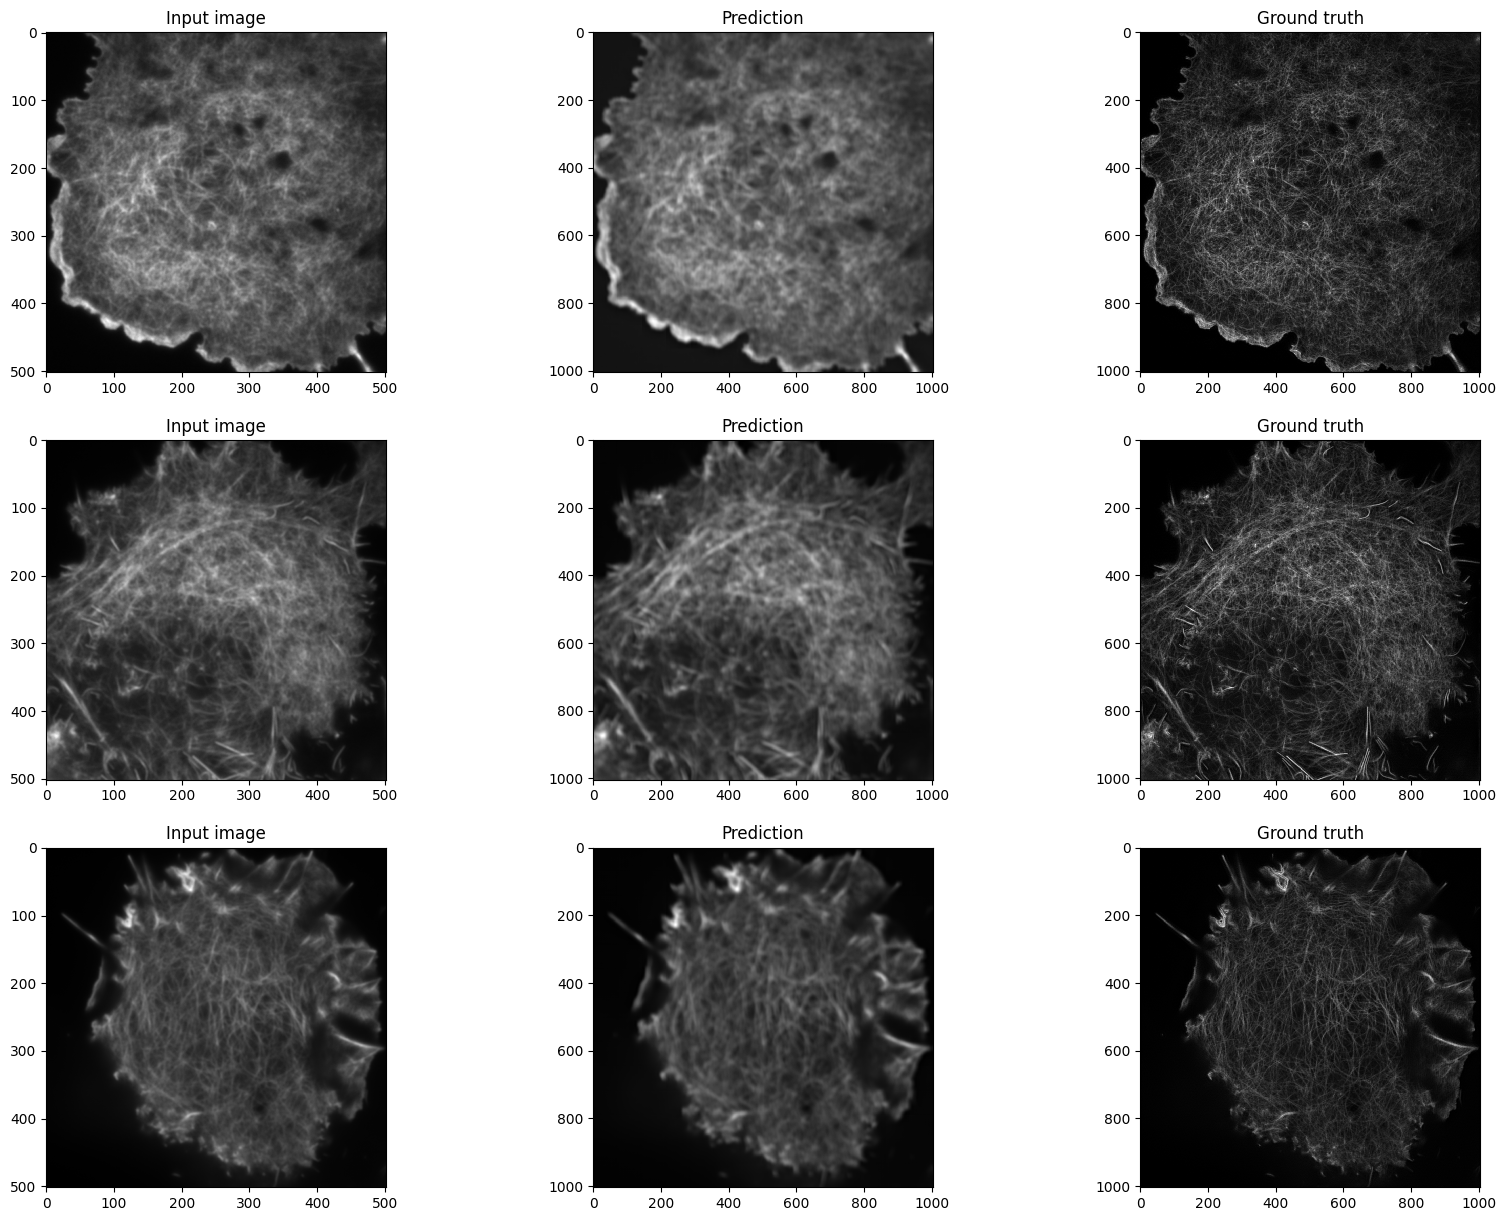

In [ ]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

sr_results = os.path.join(final_results, "per_image")
if 'STATS' in biapy_config['TEST']:
    if biapy_config['TEST']['STATS']['FULL_IMG'] == True:
        sr_results = os.path.join(final_results, "full_image")

#@markdown ##Play to visualize some results
#@markdown The results will be shown displaying:
#@markdown 1. The original **Input image**
#@markdown 2. The model **Prediction** labels
#@markdown 3. Its corresponding **Ground truth** labels

from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(sr_results))[2])
ids_input = sorted(next(os.walk(test_lr_data_path))[2])
ids_gt = sorted(next(os.walk(test_hr_data_path))[2])

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_lr_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(sr_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

    aux = imread(os.path.join(test_hr_data_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,15))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 3, index)
    plt.title("Input image")
    plt.imshow(np.squeeze(test_samples[j]), cmap='gray')

    index = index + 1
    plt.subplot(samples_to_show, 3, index)
    plt.title("Prediction")
    plt.imshow(np.squeeze(test_sample_preds[j]), cmap='gray', interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 3, index)
    plt.title("Ground truth")
    plt.imshow(np.squeeze(test_sample_gt[j]),  cmap='gray', interpolation='nearest')
    index = index + 1
plt.show()



# Download train model (weights and configuration file)
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:

#@markdown ###Play to download the model weights
from google.colab import files
checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = 'model_weights_' + str( job_name ) + '_1.h5'

files.download( os.path.join( checkpoints_path, weights_filename))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Acknowledgments**

We extend our gratitude to the [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for their invaluable inspiration. Notably, we have adopted some of their descriptions concerning metrics and parameters.
